# Image approximation using Deep *Neural Network*
---
- Author: Diego Inácio
- GitHub: [github.com/diegoinacio](https://github.com/diegoinacio)
- Notebook: [image_approximation_deepNN.ipynb](https://github.com/diegoinacio/machine-learning-notebooks/blob/master/Practical-Applications/image_approximation_deepNN.ipynb)

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

import tensorflow as tf

In [2]:
plt.rcParams['figure.figsize'] = (16, 8)

## Data exploration
---

In [3]:
n1, n2 = 128, 128
# Read Image
x = Image.open('_data/woman01.png')
# Rescale image to a lower resolution
x = x.resize((n1, n2), Image.ANTIALIAS)
x = np.asarray(x)/255
n1, n2, c = x.shape

### split channels ###
r, g, b = x[:,:,0], x[:,:,1], x[:,:,2]

In [4]:
# Transform data and produce X_train
Y_train = np.array([r.ravel(), g.ravel(), b.ravel()]).T
t, s = np.mgrid[0:n1, 0:n2]
s = (s - s.mean())/s.std()
t = (t - t.mean())/t.std()
# X_train is the normalized spatial coordinates
X_train = np.array([s.ravel(), t.ravel()], dtype=np.float32).T

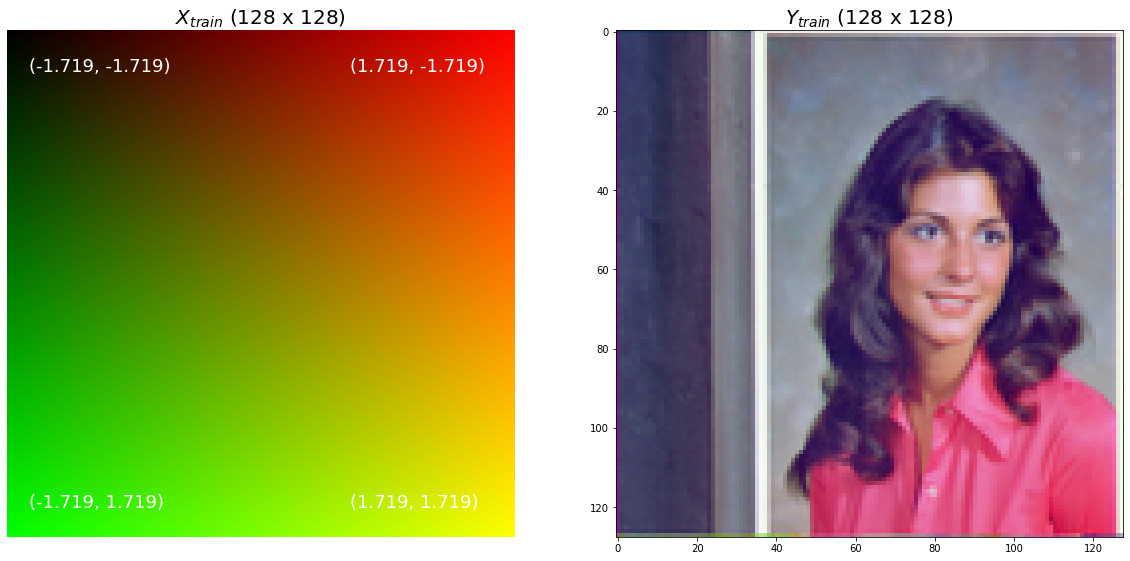

In [5]:
fig, [axA, axB] = plt.subplots(1, 2, figsize=(20, 10))

st = np.stack([s, t, s*0], axis=2)
st = (st - st.min())/(st.max() - st.min())
st[:,:,2] = 0; axA.imshow(st); axA.axis('off')
axA.text(5, 10, f'({s.min():.3f}, {t.min():.3f})', color='white', size=18)
axA.text(86, 10, f'({s.max():.3f}, {t.min():.3f})', color='white', size=18)
axA.text(5, 120, f'({s.min():.3f}, {t.max():.3f})', color='white', size=18)
axA.text(86, 120, f'({s.max():.3f}, {t.max():.3f})', color='white', size=18)
axA.set_title(f'$X_{{train}}$ ({n1} x {n2})', size=20)

axB.imshow(x)
axB.set_title(f'$Y_{{train}}$ ({n1} x {n2})', size=20)

plt.show()

In [6]:
# Produce X_test to another scale
# Upscale the image approximation
N1 = N2 = 512
t, s = np.mgrid[0:N1, 0:N2]
s = (s - s.mean())/s.std()
t = (t - t.mean())/t.std()
X_test = np.array([s.ravel(), t.ravel()], dtype=np.float32).T

print('X_train:', X_train.shape)
print('Y_train:', Y_train.shape)
print('X_test:', X_test.shape)

X_train: (16384, 2)
Y_train: (16384, 3)
X_test: (262144, 2)


## Deep Neural Network
---

In [7]:
# Avoid error: "InternalError:  Blas GEMM launch failed..." (RTX card)
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [8]:
# List of number of neurons for each hidden layer
NEURONS = [2**i for i in range(5, 11)]

# model 
# Input (2): x and y coordinates
# Output (3): RGB
model = tf.keras.Sequential([
    tf.keras.layers.Input(2),
    *[tf.keras.layers.Dense(n, activation='relu') for n in NEURONS],
    tf.keras.layers.Dense(3, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                96        
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_3 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_4 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 3

In [9]:
model.compile(
    loss='mean_squared_error',
    optimizer='adam',
    metrics=['accuracy']
)

# Train model
for i in range(5):
    print(f'\nepochs: {i*100:04d} - {(i + 1)*100:04d}')
    model.fit(
        X_train, Y_train,
        epochs=99,
        verbose=0
    )
    model.fit(
        X_train, Y_train,
        epochs=1
    )


epochs: 0000 - 0100
Train on 16384 samples
16384/16384 [==============================] - 1s 83us/sample - loss: 0.0021 - accuracy: 0.9514

epochs: 0100 - 0200
Train on 16384 samples
16384/16384 [==============================] - 1s 78us/sample - loss: 0.0016 - accuracy: 0.9579

epochs: 0200 - 0300
Train on 16384 samples
16384/16384 [==============================] - 1s 81us/sample - loss: 0.0019 - accuracy: 0.9576

epochs: 0300 - 0400
Train on 16384 samples
16384/16384 [==============================] - 1s 73us/sample - loss: 0.0014 - accuracy: 0.9582

epochs: 0400 - 0500
Train on 16384 samples
16384/16384 [==============================] - 1s 76us/sample - loss: 8.8367e-04 - accuracy: 0.9666-


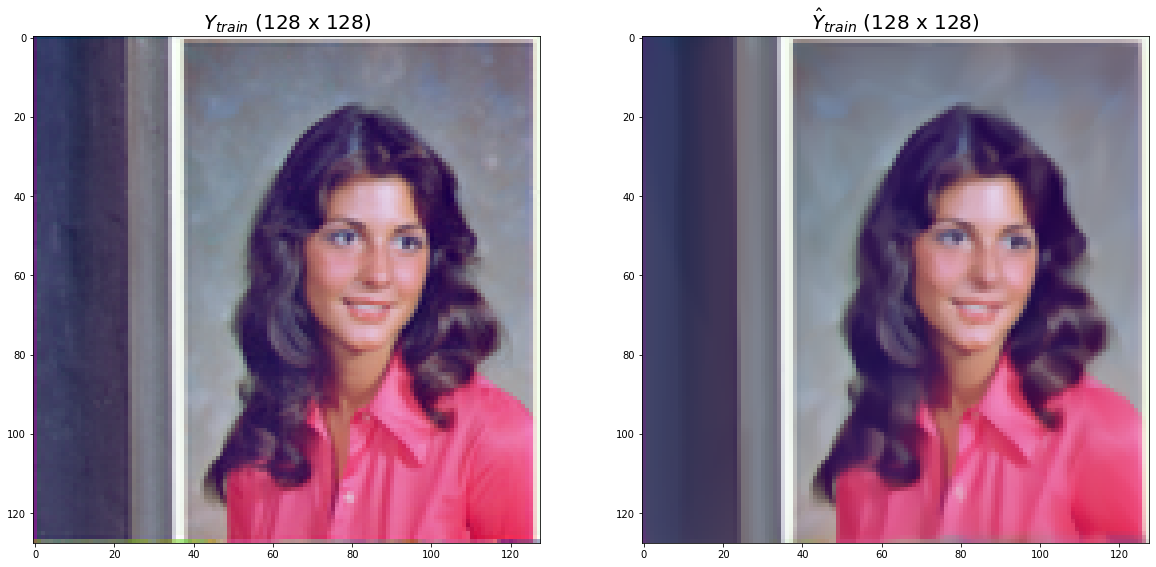

In [10]:
fig, [axA, axB] = plt.subplots(1, 2, figsize=(20, 10))

axA.imshow(x)
axA.set_title(f'$Y_{{train}}$ ({n1} x {n2})', size=20)
# Predict using X_train (128x128x3)
Y_predA = model.predict(X_train)
Y_predA = Y_predA.reshape(n1, n2, c)
axB.imshow(Y_predA)
axB.set_title(f'$\hat{{Y}}_{{train}}$ ({n1} x {n2})', size=20)

plt.show()

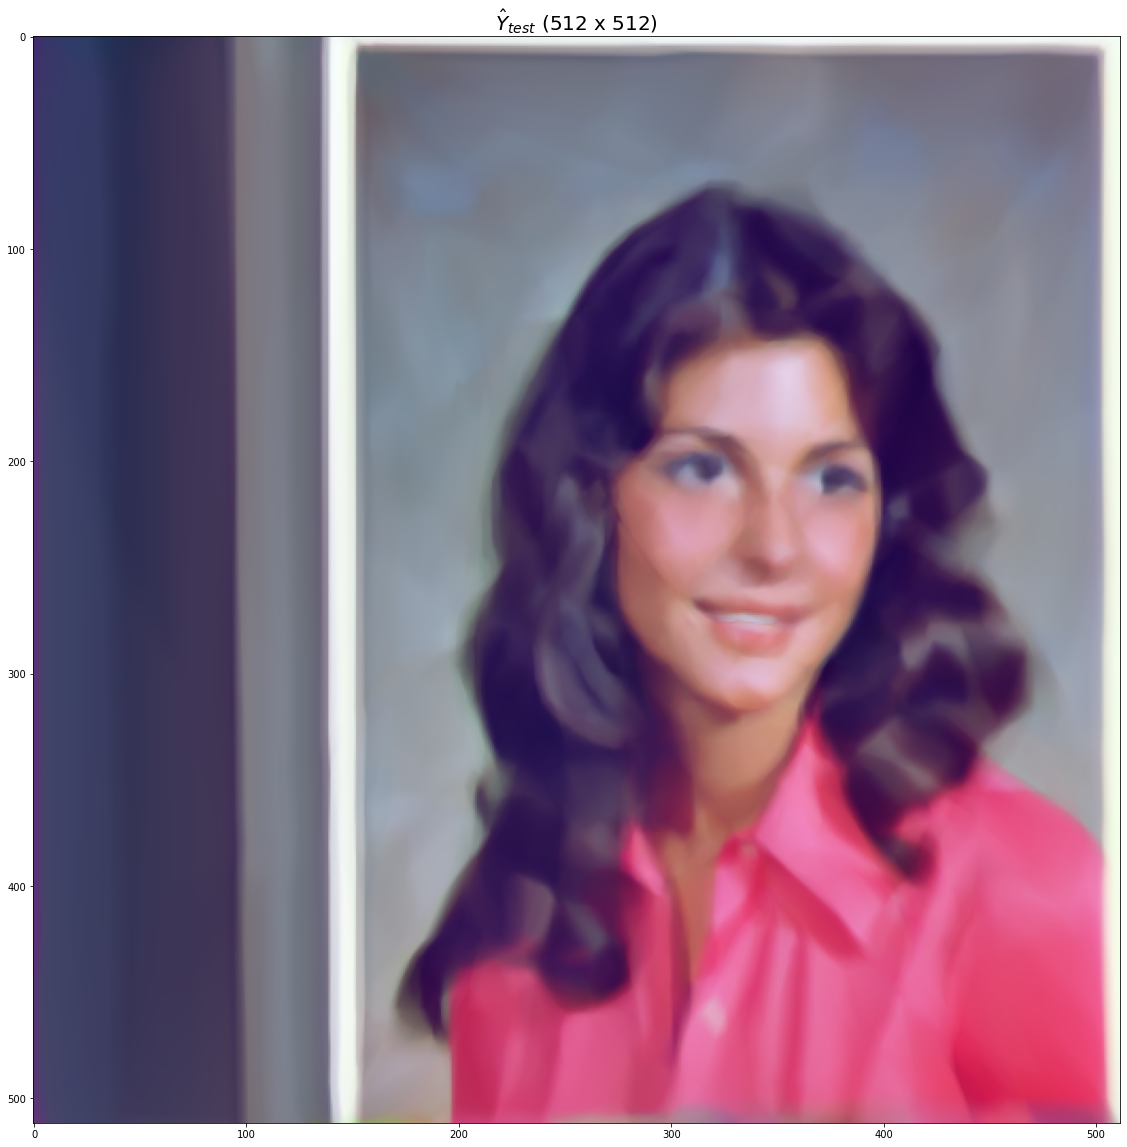

In [11]:
fig, axA = plt.subplots(1, 1, figsize=(20, 20))

# Predict using X_test (512x512x3)
Y_predB = model.predict(X_test)
Y_predB = Y_predB.reshape(N1, N2, c)
axA.imshow(Y_predB)
axA.set_title(f'$\hat{{Y}}_{{test}}$ ({N1} x {N2})', size=20)

plt.show()

## Learning process visualization
---

In [12]:
from IPython.display import HTML

HTML(
    '<iframe width="960" height="540" src="https://www.youtube.com/embed/3RplSSsfWK4" frameborder="0" allowfullscreen></iframe>'
)